# Understanding School Performance on Pennsylvania Standardized Tests

## Extended Modeling - Part 1

The solution space for extended modeling for each of our two models (ELA performance and Math performance) is as follows:

- 2 different design matrices
    - One with all original features
    - Another with highly correlated features removed


- 3 regression algorithms:
    - Random Forest
    - LightGBM
    - XGBoost
    
This will give us 6 models to compare for each of our two target variables. When training the models, we will apply hyperparameter tuning to the algorithms to attempt to minimize the mean absolute error.

### Contents

1. [Import packages and load data](#section1)
2. [Final preparation for modeling](#section2)
3. [Models for School Performance in ELA](#section3)\
    3.1 - [All original features](#section3.1)\
&emsp; 3.1.1 - [Random Forest](#section3.1.1)\
&emsp; 3.1.2 - [LightGBM](#section3.1.2)\
&emsp; 3.1.3 - [XGBoost](#section3.1.3)\
    3.2 - [High correlation features removed](#section3.2)\
&emsp; 3.2.1 - [Random Forest](#section3.2.1)\
&emsp; 3.2.2 - [LightGBM](#section3.2.2)\
&emsp; 3.2.3 - [XGBoost](#section3.2.3)

4. [Models for School Performance in Math](#section4)\
    4.1 - [All original features](#section4.1)\
&emsp; 4.1.1 - [Random Forest](#section4.1.1)\
&emsp; 4.1.2 - [LightGBM](#section4.1.2)\
&emsp; 4.1.3 - [XGBoost](#section4.1.3)\
    4.2 - [High correlation features removed](#section4.2)\
&emsp; 4.2.1 - [Random Forest](#section4.2.1)\
&emsp; 4.2.2 - [LightGBM](#section4.2.2)\
&emsp; 4.2.3 - [XGBoost](#section4.2.3)

5. [Model Selection](#section5)\
    5.1 - [ELA Model Selection](#section5.1)\
    5.2 - [Math Model Selection](#section5.2)

6. [Feature Impact](#section6)\
    6.1 - [ELA School Performance Model](#section6.1)\
    6.2 - [Math School Performance Model](#section6.2)\
    6.3 - [Feature Impact Explanations](#section6.3)


<a id='section1'></a>
## 1. Import packages and load data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# load data
X_train = pd.read_csv('../Data/X_train_scaled.csv', index_col = 0)
X_test = pd.read_csv('../Data/X_test_scaled.csv', index_col = 0)

ELA_train = pd.read_csv('../Data/y_train_ELA.csv', index_col = 0)
ELA_test = pd.read_csv('../Data/y_test_ELA.csv', index_col = 0)

math_train = pd.read_csv('../Data/y_train_math.csv', index_col = 0)
math_test = pd.read_csv('../Data/y_test_math.csv', index_col = 0)

In [3]:
# load metrics dataframe
metrics = pd.read_csv('../Data/metrics.csv', index_col = 0)
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108


In [4]:
# load highly correlated features list

open_file = open('../Data/corr_features.pkl', "rb")
corr_features = pickle.load(open_file)
open_file.close()

corr_features

['Female (School)',
 'Total Federal Expenditure',
 'English Learner',
 'White',
 'Total Personnel Expenditure',
 'Total State Expenditure',
 'Total Expenditure',
 'Total Non-Personnel Expenditure',
 'Total Local Expenditure']

<a id='section2'></a>
## 2. Final preparation for modeling

As mentioned in our plan for extended modeling above, we will take our X_train and X_test dataframes and remove the highly correlated features from them to create new dataframes.  We'll call these X_train2 and X_test2.  

Then we will convert all of these, including our target vectors into numpy arrays.

In [5]:
# drop highly correlated features to create new dataframes
X_train2 = X_train.drop(corr_features, axis = 1)
X_test2 = X_test.drop(corr_features, axis = 1)

We'll ensure that the correct number of features were dropped.

In [6]:
print(len(corr_features) == len(X_train.columns) - len(X_train2.columns))
print(len(corr_features) == len(X_test.columns) - len(X_test2.columns))

True
True


We'll save the column labels prior to converting to numpy arrays.

In [7]:
cols = X_train.columns
cols2 = X_train2.columns

We'll also convert all of our pandas objects into numpy arrays.

In [8]:
# convert datasets with all original features
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# convert datasets with highly correlated features removed
X_train2 = X_train2.to_numpy()
X_test2 = X_test2.to_numpy()

# ELA target variable
ELA_train = ELA_train.to_numpy().ravel()
ELA_test = ELA_test.to_numpy().ravel()

#math target variable
math_train = math_train.to_numpy().ravel()
math_test = math_test.to_numpy().ravel()

Finally, we'll define our functions that will graph our model results as well as generate/add metrics to our metrics table.

In [9]:
def graph_residuals(Subject, Features, Algorithm, y_train, y_train_pred, y_test, y_test_pred):
    """Function that will graph actual vs. predicted, residual plot and distribution of residuals"""
    residual_train = y_train - y_train_pred
    residual_test = y_test - y_test_pred
    
    r2_train = str(round(r2_score(y_train, y_train_pred), 4))
    r2_test = str(round(r2_score(y_test, y_test_pred), 4))
    
    train_var = str(round(np.var(residual_train), 2))
    test_var = str(round(np.var(residual_test), 2))
    
    print('Graphs for')
    print('Target:', Subject, 'Performance')
    print('Features:', Features)
    print('Algorithm:', Algorithm)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    
    ax1.scatter(y_train, y_train_pred, alpha = 0.6, color = 'steelblue', label = 'Train')
    ax1.scatter(y_test, y_test_pred, alpha = 0.6, color = 'yellowgreen', label = 'Test')
    ax1.plot([x for x in range(0, 100)],[x for x in range(0, 100)], color='black')
    ax1.set_title('Actual vs. Predicted')
    ax1.set_ylabel('Predicted Values')
    ax1.set_xlabel('Actual Values')
    ax1.legend(loc='upper left')
    
    ax2.scatter(y_train_pred, residual_train, alpha = 0.6, color = 'steelblue',
                label = 'Train ' + "$" + 'R^2' + "$" + ' = ' + r2_train)
    ax2.scatter(y_test_pred, residual_test, alpha = 0.6, color = 'yellowgreen',
                label = 'Test ' + "$" + 'R^2' + "$" + ' = ' + r2_test)
    ax2.axhline(y=0, color = 'black')
    ax2.set_title('Residual Plot')
    ax2.set_ylabel('Residuals')
    ax2.set_xlabel('Predicted Values')
    ax2.legend(loc='upper left')

    ax3.hist(residual_train,  bins = 30, color = 'steelblue', label = 'Train Variance = ' + train_var)
    ax3.hist(residual_test, bins = 30, alpha = 0.8, color = 'yellowgreen', label = 'Test Variance = ' + test_var)
    ax3.axvline(x=0, color = 'black')
    ax3.set_title('Distribution of Residuals')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Count')
    ax3.legend(loc='upper left')

    plt.show()

In [10]:
def add_metrics(Subject, Features, Algorithm, y_train, y_train_pred, y_test, y_test_pred):

    new_row = {'Subject':Subject,
               'Features':Features,
               'Algorithm':Algorithm,
               'Train r2': r2_score(y_train, y_train_pred),
               'Train MAE': mean_absolute_error(y_train, y_train_pred),
               'Train 95% Worst Case Error LB': np.percentile(y_train - y_train_pred, 2.5),
               'Train 95% Worst Case Error UB': np.percentile(y_train - y_train_pred, 97.5),
               'Test r2': r2_score(y_test, y_test_pred),
               'Test MAE': mean_absolute_error(y_test, y_test_pred),
               'Test 95% Worst Case Error LB': np.percentile(y_test - y_test_pred, 2.5),
               'Test 95% Worst Case Error UB': np.percentile(y_test - y_test_pred, 97.5)
              }
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

Define our parameter grids and scoring method for each of our three algorithms in preparation for hyperparameter tuning using RandomSearchCV.

In [11]:
# random forest params
params_rf = {'n_estimators':[5,20,50,100],
             'max_depth':[int(x) for x in np.linspace(10, 120, num = 12)],
             'max_features':['auto', 'sqrt'],
             'min_samples_leaf':[1, 3, 5],
             'min_samples_split':[2, 6, 10],
            }

# LightGBM params
params_lg = {'n_estimators':[20,40,60,80,100],
             'num_leaves':[20,40,60,80,100], 
             'min_child_samples':[5,10,15],
             'max_depth':[5,10,20,40],
             'learning_rate':[0.05,0.1,0.2],
             'reg_alpha':[0,0.05,0.1,0.2]
            }


# XGBoost params
params_xg = {
        'min_child_weight': [6, 8, 10, 12],
        'gamma': [1, 2, 5, 10],
        'subsample': np.arange(0.1, 1.0, 0.1),
        'colsample_bytree': np.arange(0.1, 1.0, 0.1),
        'max_depth': [3, 5, 7, 10, 12],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        }

#scoring method for RandomSearchCV
scoring = 'neg_mean_absolute_error'

<a id='section3'></a>
## 3. Models for School Performance in ELA

<a id='section3.1'></a>
### 3.1 ELA - All original features

<a id='section3.1.1'></a>
#### 3.1.1 Random Forest

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> Random Forest

In [12]:
# Instantiate a random forest regressor 
rf_ELA = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_ELA.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [13]:
# Instantiate a k-fold CV random search object
rand_rf_ELA = RandomizedSearchCV(estimator=rf_ELA,
                                   param_distributions=params_rf,
                                   n_iter = 200,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_ELA.fit(X_train, ELA_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_ELA = rand_rf_ELA.best_estimator_
    

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.3min finished


Best hyerparameters:
 {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70}


In [14]:
# Make predictions
ELA_train_pred_rf = best_rf_ELA.predict(X_train)
ELA_test_pred_rf = best_rf_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: Random Forest


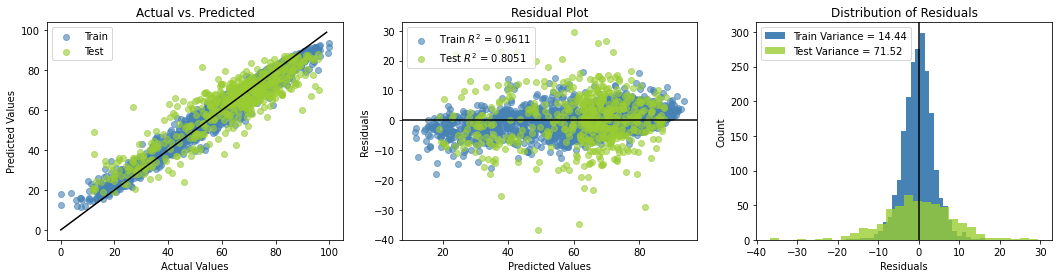

In [15]:
#Graph results
graph_residuals('ELA', 
            'All features',
            'Random Forest', 
            ELA_train, 
            ELA_train_pred_rf, 
            ELA_test, 
            ELA_test_pred_rf)

In [16]:
add_metrics('ELA', 
            'All features',
            'Random Forest', 
            ELA_train, 
            ELA_train_pred_rf, 
            ELA_test, 
            ELA_test_pred_rf)

In [17]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975


Our Random Forest model does seem to improve on our baseline Linear Regression model.  The MAE value is lower  by about 0.5 percentage points and the worst case lower bound and upper bound of residuals is a smaller intervval than those of our baseline. With that said, judging by the graphs and the metrics, it looks like the random forest model is overfitting the training data. 

<a id='section3.1.2'></a>
#### 3.1.2 LightGBM

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> LightGBM

In [18]:
# Initiate LightGBM regressor
lg_ELA = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_ELA.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [19]:
# Instantiate a k-fold CV random search object
rand_lg_ELA = RandomizedSearchCV(estimator=lg_ELA,
                                 param_distributions=params_lg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_ELA.fit(X_train, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_ELA = rand_lg_ELA.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.1, 'num_leaves': 40, 'n_estimators': 100, 'min_child_samples': 15, 'max_depth': 40, 'learning_rate': 0.05}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.0min finished


In [20]:
# Make predictions
ELA_train_pred_lg = best_lg_ELA.predict(X_train)
ELA_test_pred_lg = best_lg_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: LightGBM


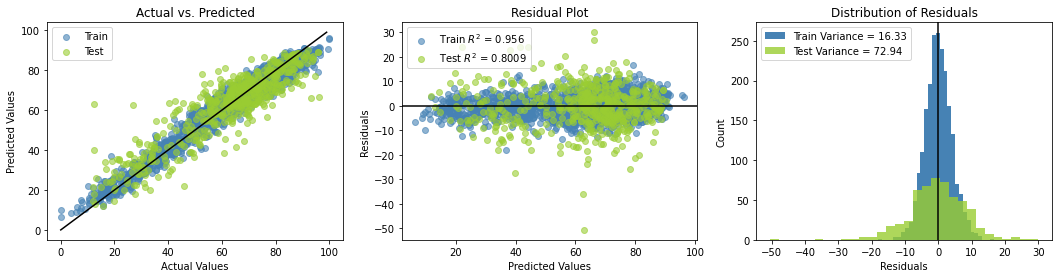

In [21]:
#Graph results
graph_residuals('ELA', 
                'All features',
                'LightGBM', 
                ELA_train, 
                ELA_train_pred_lg, 
                ELA_test, 
                ELA_test_pred_lg)

In [22]:
#add metrics
add_metrics('ELA', 
            'All features',
            'LightGBM', 
            ELA_train, 
            ELA_train_pred_lg, 
            ELA_test, 
            ELA_test_pred_lg)

In [23]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946


The LightGBM model is definitely an improvement on our baseline.  The test performance is similar to our previous Random Forest model.  While there definitely is some overfitting, it does not seem as severe as our Random Forest model.

<a id='section3.1.3'></a>
#### 3.1.3 XGBoost

<u>Target:</u> ELA Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> XGBoost

In [24]:
# Initiate LightGBM regressor
xg_ELA = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_ELA.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [25]:
# Instantiate a k-fold CV random search object
rand_xg_ELA = RandomizedSearchCV(estimator=xg_ELA,
                                 param_distributions=params_xg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_ELA.fit(X_train, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_ELA.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_ELA = rand_xg_ELA.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.5}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.4min finished


In [26]:
# Make predictions
ELA_train_pred_xg = best_xg_ELA.predict(X_train)
ELA_test_pred_xg = best_xg_ELA.predict(X_test)

Graphs for
Target: ELA Performance
Features: All features
Algorithm: XGBoost


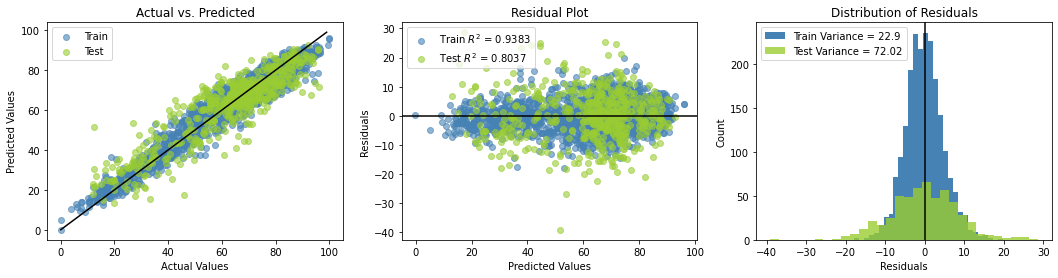

In [27]:
#Graph results
graph_residuals('ELA', 
            'All features',
            'XGBoost', 
            ELA_train, 
            ELA_train_pred_xg, 
            ELA_test, 
            ELA_test_pred_xg)

In [28]:
#add metrics
add_metrics('ELA', 
            'All features',
            'XGBoost', 
            ELA_train, 
            ELA_train_pred_xg, 
            ELA_test, 
            ELA_test_pred_xg)

In [29]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438


The XGBoost model is definitely subject to more overfitting, but the test performance seems to be similar to the LGBM and Random Forest models.  

<a id='section3.2'></a>
### 3.2 ELA - High correlation features removed

<a id='section3.2.1'></a>
#### 3.2.1 Random Forest

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> Random Forest

In [30]:
# Instantiate a random forest regressor 
rf_ELA2 = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_ELA2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [31]:
# Instantiate a k-fold CV random search object
rand_rf_ELA2 = RandomizedSearchCV(estimator=rf_ELA2,
                                   param_distributions=params_rf,
                                   n_iter = 200,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_ELA2.fit(X_train2, ELA_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_ELA2 = rand_rf_ELA2.best_estimator_
    

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.5min finished


Best hyerparameters:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}


In [32]:
# Make predictions
ELA2_train_pred_rf = best_rf_ELA2.predict(X_train2)
ELA2_test_pred_rf = best_rf_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: Random Forest


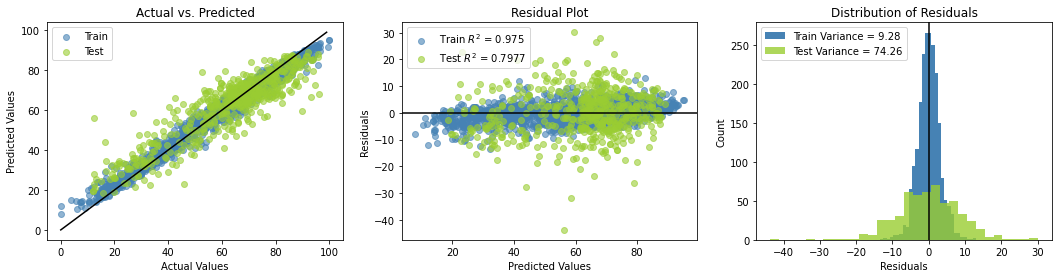

In [33]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'Random Forest', 
                ELA_train, 
                ELA2_train_pred_rf, 
                ELA_test, 
                ELA2_test_pred_rf
               )

In [34]:
#add metrics to metrics table
add_metrics('ELA', 
            'High corr features removed',
            'Random Forest', 
            ELA_train, 
            ELA2_train_pred_rf, 
            ELA_test, 
            ELA2_test_pred_rf
            )

In [35]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000


Running the random forest model on the data with high correlation features removed shows that it is also subject overfitting in a slightly more extreme case than the original random forest model.  

On the training set, this model produced a higher $r^2$ score, a lower MAE, and a smaller interval for worst case lower and upper bounds compared to the original random forest model.

On the test set, this model produced a lower $r^2$ score, a higher MAE, and a larger interval for worst case lower and upper bounds compared to the original random forest model.

<a id='section3.2.2'></a>
#### 3.2.2 LightGBM

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> LightGBM

In [36]:
# Initiate LightGBM regressor
lg_ELA2 = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_ELA2.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [37]:
# Instantiate a k-fold CV random search object
rand_lg_ELA2 = RandomizedSearchCV(estimator=lg_ELA2,
                                 param_distributions=params_lg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_ELA2.fit(X_train2, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_ELA2 = rand_lg_ELA2.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 80, 'n_estimators': 80, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.1}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   52.3s finished


In [38]:
# Make predictions
ELA2_train_pred_lg = best_lg_ELA2.predict(X_train2)
ELA2_test_pred_lg = best_lg_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: LightGBM


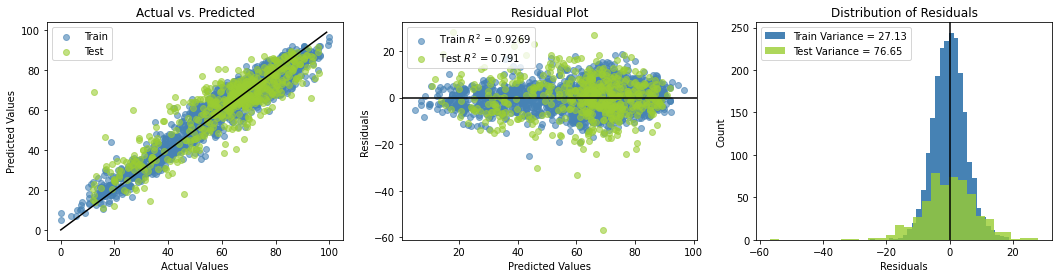

In [39]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'LightGBM', 
                ELA_train, 
                ELA2_train_pred_lg, 
                ELA_test, 
                ELA2_test_pred_lg)

In [40]:
add_metrics('ELA', 
            'High corr features removed',
            'LightGBM', 
            ELA_train, 
            ELA2_train_pred_lg, 
            ELA_test, 
            ELA2_test_pred_lg)

In [41]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370


Running the LightGBM model with our high correlation features removed gives a similar comparison to its original LightGBM as the random forest comparison earlier.  There is definitely a higher degree of overfitting compared to the original LightGBM.

On the training set, this model produced a higher $r^2$ score, a lower MAE, and a smaller interval for worst case lower and upper bounds compared to the original random forest model.

On the test set, this model produced a lower $r^2$ score, a higher MAE, and a larger interval for worst case lower and upper bounds compared to the original random forest model.

<a id='section3.2.3'></a>
#### 3.2.3 XGBoost

<u>Target:</u> ELA Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> XGBoost

In [42]:
# Initiate LightGBM regressor
xg_ELA2 = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_ELA2.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [43]:
# Instantiate a k-fold CV random search object
rand_xg_ELA2 = RandomizedSearchCV(estimator=xg_ELA2,
                                 param_distributions=params_xg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_ELA2.fit(X_train2, ELA_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_ELA2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_ELA2 = rand_xg_ELA2.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 10, 'colsample_bytree': 0.6}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.2min finished


In [44]:
# Make predictions
ELA2_train_pred_xg = best_xg_ELA2.predict(X_train2)
ELA2_test_pred_xg = best_xg_ELA2.predict(X_test2)

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: XGBoost


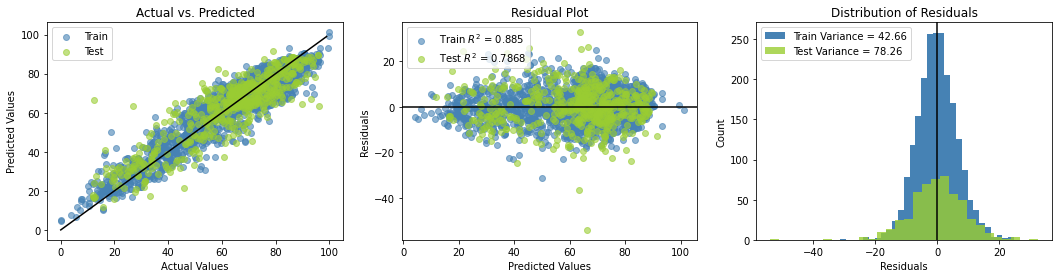

In [45]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'XGBoost', 
                ELA_train, 
                ELA2_train_pred_xg, 
                ELA_test, 
                ELA2_test_pred_xg)

In [46]:
add_metrics('ELA', 
            'High corr features removed',
            'XGBoost', 
            ELA_train, 
            ELA2_train_pred_xg, 
            ELA_test, 
            ELA2_test_pred_xg)

In [47]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635


When we run our XGBoost model with high correlation features removed, it seems to overfit less than with all original features included.  However, the performance is not as strong, with lower $r^2$ score, higher MAE, and slightly larger interval for worst case lower and upper bound residuals.

<a id='section4'></a>
## 4. Models for School Performance in Math

<a id='section4.1'></a>
### 4.1 Math - All original features

<a id='section4.1.1'></a>
#### 4.1.1 Random Forest

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> Random Forest

In [48]:
# Instantiate a random forest regressor 
rf_math = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_math.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [49]:
# Instantiate a k-fold CV random search object
rand_rf_math = RandomizedSearchCV(estimator=rf_math,
                                   param_distributions=params_rf,
                                   n_iter = 200,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_math.fit(X_train, math_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_math = rand_rf_math.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.3min finished


Best hyerparameters:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 30}


In [50]:
# Make predictions
math_train_pred_rf = best_rf_math.predict(X_train)
math_test_pred_rf = best_rf_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: Random Forest


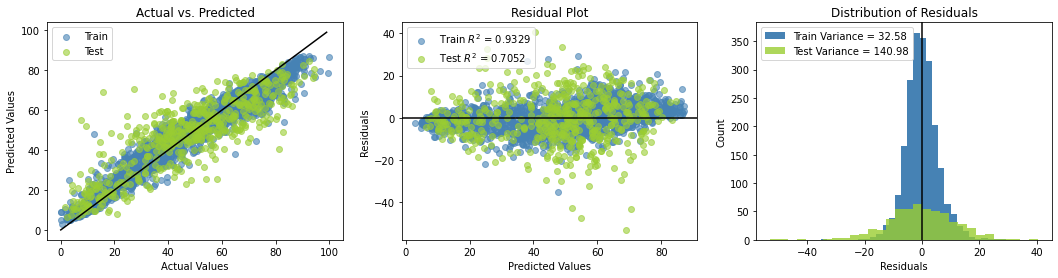

In [51]:
#Graph results
graph_residuals('Math', 
                'All features',
                'Random Forest', 
                math_train, 
                math_train_pred_rf, 
                math_test, 
                math_test_pred_rf)

In [52]:
add_metrics('Math', 
            'All features',
            'Random Forest', 
            math_train, 
            math_train_pred_rf, 
            math_test, 
            math_test_pred_rf)

In [53]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854


When training our Random Forest model with Math Performance as the target variable, there seems to be a high degree of overfitting, particularly in comparison to our baseline linear regression model.

We'll see if we can create models that generalize better using LightGMB and XGBoost.

<a id='section4.1.2'></a>
#### 4.1.2 LightGBM

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> LightGBM

In [54]:
# Initiate LightGBM regressor
lg_math = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_math.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [55]:
# Instantiate a k-fold CV random search object
rand_lg_math = RandomizedSearchCV(estimator=lg_math,
                                 param_distributions=params_lg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_math.fit(X_train, math_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_math = rand_lg_math.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 20, 'n_estimators': 60, 'min_child_samples': 10, 'max_depth': 40, 'learning_rate': 0.1}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.0min finished


In [56]:
# Make predictions
math_train_pred_lg = best_lg_math.predict(X_train)
math_test_pred_lg = best_lg_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: LightGBM


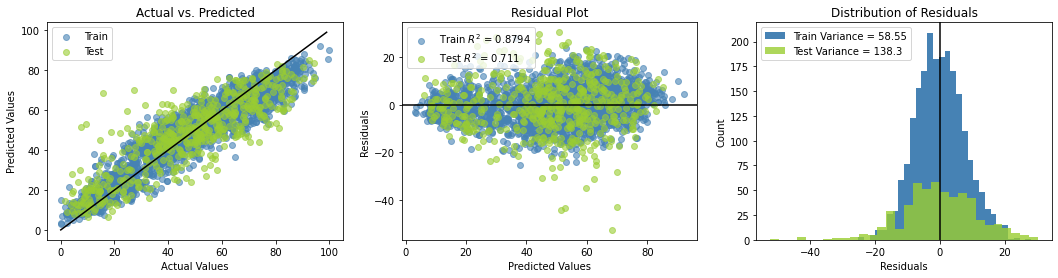

In [57]:
#Graph results
graph_residuals('Math', 
                'All features',
                'LightGBM', 
                math_train, 
                math_train_pred_lg, 
                math_test, 
                math_test_pred_lg)

In [58]:
#add metrics
add_metrics('Math', 
            'All features',
            'LightGBM', 
            math_train, 
            math_train_pred_lg, 
            math_test, 
            math_test_pred_lg)

In [59]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854
9,Math,All features,LightGBM,0.879351,6.107250,-14.676186,15.994863,0.711010,9.084958,-23.186311,22.527107


The LightGBM model is still subject to some overfitting, but its performance can be considered better than the Random Forest model according to certain metrics.  It has a higher test $r^2$ score and a lower MAE.

<a id='section4.1.3'></a>
#### 4.1.3 XGBoost

<u>Target:</u> Math Performance\
<u>Features:</u> All original features\
<u>Algorithm:</u> XGBoost

In [60]:
# Initiate LightGBM regressor
xg_math = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_math.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [61]:
# Instantiate a k-fold CV random search object
rand_xg_math = RandomizedSearchCV(estimator=xg_math,
                                 param_distributions=params_xg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_math.fit(X_train, math_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_math.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_math = rand_xg_math.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.5min finished


Best hyerparameters:
 {'subsample': 0.7000000000000001, 'min_child_weight': 10, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 10, 'colsample_bytree': 0.8}


In [62]:
# Make predictions
math_train_pred_xg = best_xg_math.predict(X_train)
math_test_pred_xg = best_xg_math.predict(X_test)

Graphs for
Target: Math Performance
Features: All features
Algorithm: XGBoost


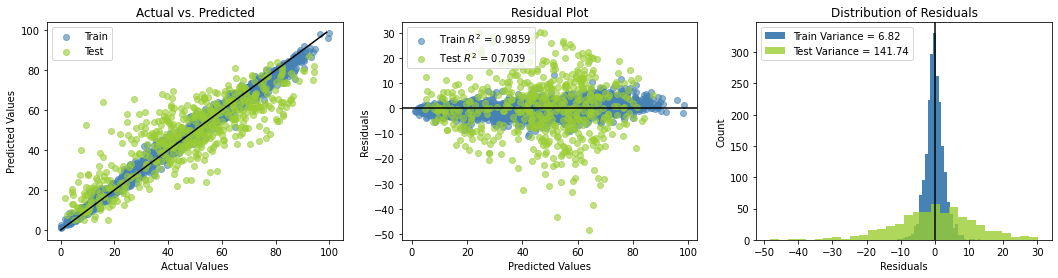

In [63]:
#Graph results
graph_residuals('Math', 
                'All features',
                'XGBoost', 
                math_train, 
                math_train_pred_xg, 
                math_test, 
                math_test_pred_xg)

In [64]:
#add metrics
add_metrics('Math', 
            'All features',
            'XGBoost', 
            math_train, 
            math_train_pred_xg, 
            math_test, 
            math_test_pred_xg)

In [65]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854
9,Math,All features,LightGBM,0.879351,6.107250,-14.676186,15.994863,0.711010,9.084958,-23.186311,22.527107


When modeling our math school performance target variable with XGBoost, the comparison between its train metrics and test metrics show that there is a high degree of overfitting.  While it has the best training metrics, it has the worst test metrics out of the three models so far.

Next, we'll see if removing our high correlation features will improve performance for our math models.

<a id='section4.2'></a>
### 4.2 Math - High correlation features removed

<a id='section4.2.1'></a>
#### 4.2.1 Random Forest

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> Random Forest

In [66]:
# Instantiate a random forest regressor 
rf_math2 = RandomForestRegressor(random_state = 16)

# Print out hyperparameters
print(rf_math2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 16, 'verbose': 0, 'warm_start': False}


In [67]:
# Instantiate a k-fold CV random search object
rand_rf_math2 = RandomizedSearchCV(estimator=rf_math2,
                                   param_distributions=params_rf,
                                   n_iter = 200,
                                   scoring=scoring,
                                   cv=3,
                                   verbose=1,
                                   n_jobs=1,
                                   random_state=16
                                )

# Fit train model
rand_rf_math2.fit(X_train2, math_train)
    
# Extract best hyperparameters
best_hyperparams = rand_rf_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_rf_math2 = rand_rf_math2.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.4min finished


Best hyerparameters:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 30}


In [68]:
# Make predictions
math2_train_pred_rf = best_rf_math2.predict(X_train2)
math2_test_pred_rf = best_rf_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: Random Forest


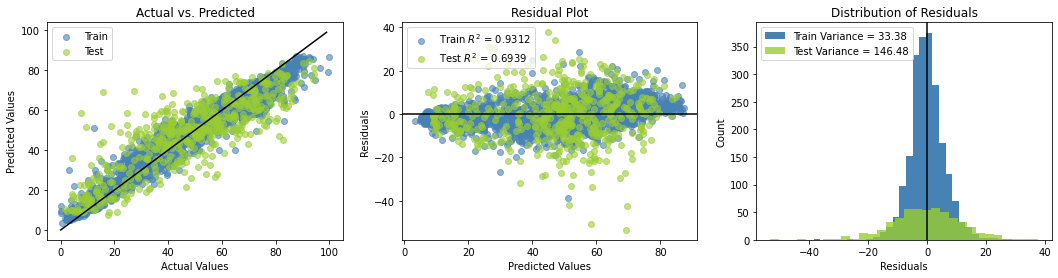

In [69]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'Random Forest', 
                math_train, 
                math2_train_pred_rf, 
                math_test, 
                math2_test_pred_rf
               )

In [70]:
#add metrics to metrics table
add_metrics('Math', 
            'High corr features removed',
            'Random Forest', 
            math_train, 
            math2_train_pred_rf, 
            math_test, 
            math2_test_pred_rf
            )

In [71]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854
9,Math,All features,LightGBM,0.879351,6.107250,-14.676186,15.994863,0.711010,9.084958,-23.186311,22.527107


In comparison to the original Random Forest model for math using all original features, this random forest model performs just slightly worse.  The test $r^2$ score is slightly lower, while the MAE is slightly larger and the upper and lower bounds of the worst case residuals are wider.

<a id='section4.2.2'></a>
#### 4.2.2 LightGBM

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> LightGBM

In [72]:
# Initiate LightGBM regressor
lg_math2 = lgb.LGBMRegressor(random_state = 16)

# Print out hyperparameters
print(lg_math2.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 16, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [73]:
# Instantiate a k-fold CV random search object
rand_lg_math2 = RandomizedSearchCV(estimator=lg_math2,
                                 param_distributions=params_lg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_lg_math2.fit(X_train2, math_train)

# Extract best hyperparameters
best_hyperparams = rand_lg_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_lg_math2 = rand_lg_math2.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'reg_alpha': 0.2, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 15, 'max_depth': 10, 'learning_rate': 0.05}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   53.1s finished


In [74]:
# Make predictions
math2_train_pred_lg = best_lg_math2.predict(X_train2)
math2_test_pred_lg = best_lg_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: LightGBM


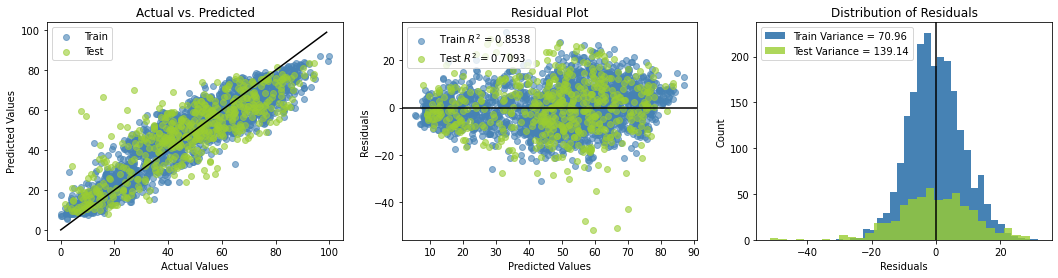

In [75]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'LightGBM', 
                math_train, 
                math2_train_pred_lg, 
                math_test, 
                math2_test_pred_lg)

In [76]:
add_metrics('Math', 
            'High corr features removed',
            'LightGBM', 
            math_train, 
            math2_train_pred_lg, 
            math_test, 
            math2_test_pred_lg)

In [77]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854
9,Math,All features,LightGBM,0.879351,6.107250,-14.676186,15.994863,0.711010,9.084958,-23.186311,22.527107


Our LightGBM model for math performance with the high correlation features removed also performs slightly worse than the original LightGBM model.  The test $r^2$ score is lower and the MAE is larger.

<a id='section4.2.3'></a>
#### 4.2.3 XGBoost

<u>Target:</u> Math Performance\
<u>Features:</u> High correlation features removed\
<u>Algorithm:</u> XGBoost

In [78]:
# Initiate XGBoost regressor
xg_math2 = xgb.XGBRegressor(random_state = 16)

# Print out hyperparameters
print(xg_math2.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 16, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [79]:
# Instantiate a k-fold CV random search object
rand_xg_math2 = RandomizedSearchCV(estimator=xg_math2,
                                 param_distributions=params_xg,
                                 n_iter = 200,
                                 scoring=scoring,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=1,
                                 random_state=16
                                )

# Fit train model
rand_xg_math2.fit(X_train2, math_train)

# Extract best hyperparameters
best_hyperparams = rand_xg_math2.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_xg_math2 = rand_xg_math2.best_estimator_



Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best hyerparameters:
 {'subsample': 0.6, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.9}


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.3min finished


In [80]:
# Make predictions
math2_train_pred_xg = best_xg_math2.predict(X_train2)
math2_test_pred_xg = best_xg_math2.predict(X_test2)

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: XGBoost


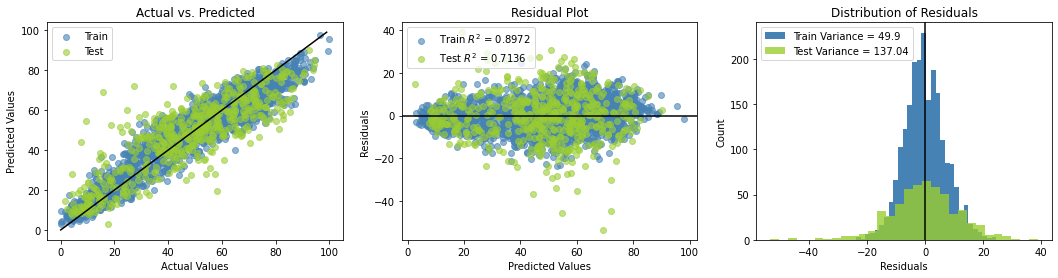

In [81]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'XGBoost', 
                math_train, 
                math2_train_pred_xg, 
                math_test, 
                math2_test_pred_xg)

In [82]:
add_metrics('Math', 
            'High corr features removed',
            'XGBoost', 
            math_train, 
            math2_train_pred_xg, 
            math_test, 
            math2_test_pred_xg)

In [83]:
metrics

,Subject,Features,Algorithm,Train r2,Train MAE,Train 95% Worst Case Error LB,Train 95% Worst Case Error UB,Test r2,Test MAE,Test 95% Worst Case Error LB,Test 95% Worst Case Error UB
0,ELA,All features,Linear Regression (baseline),0.799005,6.677475,-16.547091,17.187611,0.771052,6.948462,-18.039068,17.495580
1,Math,All features,Linear Regression (baseline),0.700370,9.679650,-22.831911,24.116995,0.655321,10.117124,-24.413786,23.483108
2,ELA,All features,Random Forest,0.961075,2.890764,-7.782669,7.566408,0.805139,6.497471,-16.154838,15.063975
3,ELA,All features,LightGBM,0.955997,3.171461,-7.720022,8.272880,0.800910,6.442666,-17.486166,15.218946
4,ELA,All features,XGBoost,0.938279,3.734490,-9.427653,9.978167,0.803726,6.536641,-16.647049,16.264438
5,ELA,High corr features removed,Random Forest,0.974988,2.340604,-5.880125,6.202650,0.797670,6.653331,-16.768200,15.926000
6,ELA,High corr features removed,LightGBM,0.926881,4.092911,-9.977320,10.540078,0.791025,6.616683,-17.087353,16.713370
7,ELA,High corr features removed,XGBoost,0.885043,5.091457,-12.362323,13.495411,0.786773,6.684302,-17.113285,16.263635
8,Math,All features,Random Forest,0.932877,4.295454,-10.943972,12.230963,0.705218,9.133873,-23.429704,22.108854
9,Math,All features,LightGBM,0.879351,6.107250,-14.676186,15.994863,0.711010,9.084958,-23.186311,22.527107


When removing high correlation features from our dataset, the XGBoost model performs better for math than its original counterpart.  There is still a certain degree of overfitting, but the train and test set metrics are certainly closer than the original XGBoost model.  Additionally, the test $r^2$ score is higher, the MAE is lower and the worst case upper and lower bound interval for residuals is smaller.

<a id='section5'></a>
## 5. Model Selection

In order to better understand our table of metrics and compare the scores, we'll generate separate bar plots for each metric to compare how the models scored.

In [84]:
#create a copy of our metrics dataframe
metrics2 = metrics

#add a column for 'Model', combining the Algorithm with the feature type
metrics2['Model'] = metrics2['Algorithm'] + ' with ' + metrics2['Features']

<a id='section5.1'></a>
### 5.1 ELA Model Selection

We'll create new tables for each of our three metrics so that we can easily graph them.

In [85]:
#melt metrics2 dataframe to create r2 table
metrics_ELA_r2 = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                           value_vars=['Train r2', 'Test r2'],
                                                           var_name = 'Type',
                                                           value_name = 'r2')

#replace values in 'Type' column
metrics_ELA_r2["Type"].replace({"Train r2": "Train", 
                                 "Test r2": "Test"
                                }, 
                                inplace=True)

In [86]:
#melt metrics2 dataframe to create MAE table
metrics_ELA_MAE = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                            value_vars=['Train MAE', 'Test MAE'],
                                                            var_name = 'Type',
                                                            value_name = 'MAE'
                                                           )
#replace values in 'Type' column
metrics_ELA_MAE["Type"].replace({"Train MAE": "Train", 
                                 "Test MAE": "Test"
                                }, 
                                inplace=True)

In [87]:
#melt metrics2 dataframe to create table for worst case residuals
metrics_ELA_res = metrics2[metrics2['Subject']=='ELA'].melt(id_vars=['Model'], 
                                                            value_vars=['Train 95% Worst Case Error LB',
                                                                        'Train 95% Worst Case Error UB',
                                                                        'Test 95% Worst Case Error LB',
                                                                        'Test 95% Worst Case Error UB'],
                                                            var_name = 'Type',
                                                            value_name = 'Worst Case'
                                                           )
#replace values in 'Type' column
metrics_ELA_res["Type"].replace({"Train 95% Worst Case Error LB": "Train", 
                                 "Train 95% Worst Case Error UB": "Train",
                                 'Test 95% Worst Case Error LB':'Test',
                                 'Test 95% Worst Case Error UB':'Test'
                                }, 
                                inplace=True)

We'll start by comparing the $r^2$ score of all the models.  

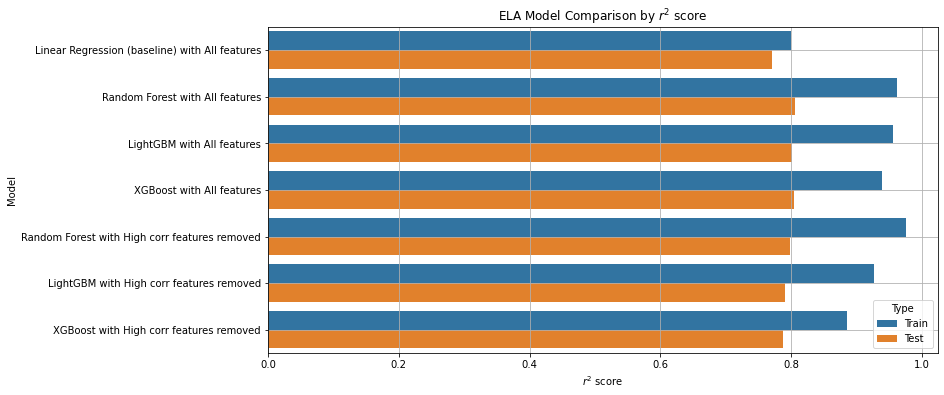

In [88]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'r2', y = 'Model', hue = 'Type', data = metrics_ELA_r2)
ax.set_xlabel('$r^2$ score')
ax.set_title('ELA Model Comparison by $r^2$ score')
plt.grid()
plt.show()

Next we'll compare the Mean Absolute Error of our models.

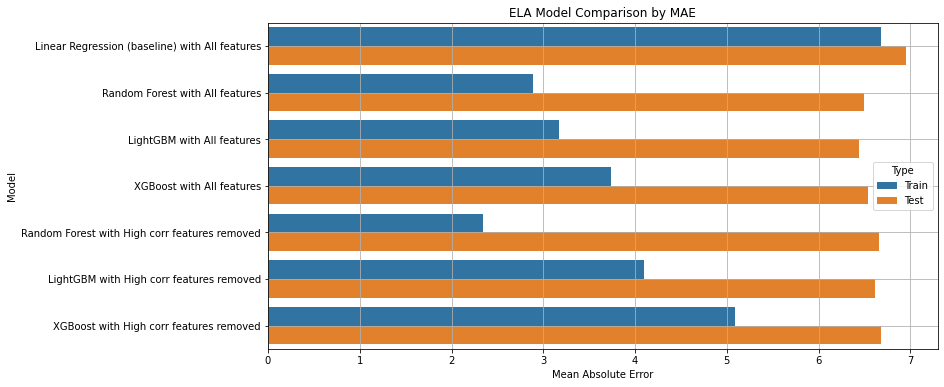

In [89]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'MAE', y = 'Model', hue = 'Type', data = metrics_ELA_MAE)
ax.set_xlabel('Mean Absolute Error')
ax.set_title('ELA Model Comparison by MAE')
plt.grid()
plt.show()

And finally we'll compare the worst case upper and lower bounds of our residuals.

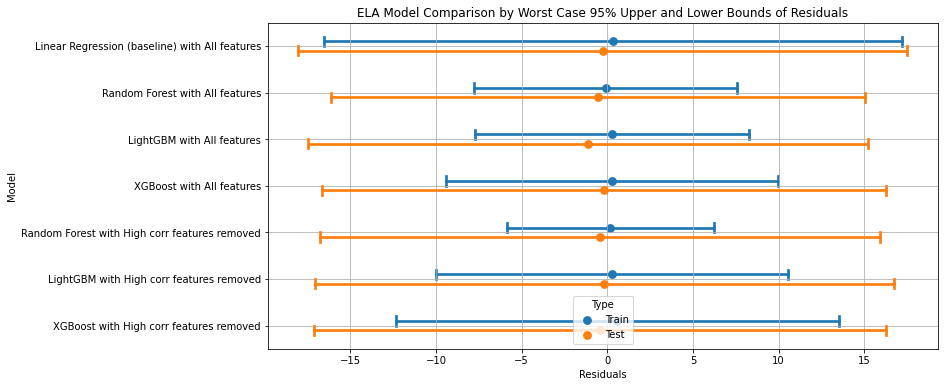

In [90]:
plt.figure(figsize=(12,6))

ax = sns.pointplot(x = 'Worst Case', 
                   y='Model', 
                   hue = 'Type', 
                   data = metrics_ELA_res, 
                   dodge=0.2, 
                   join=False,
                   capsize=0.2
                  )

ax.set_xlabel('Residuals')
ax.set_title('ELA Model Comparison by Worst Case 95% Upper and Lower Bounds of Residuals')
plt.grid()
plt.show()

There is no clear winner amoung our models for predicting school performance in ELA.  All of our 6 models improve on our baseline linear regression model, but their metrics vary.  

While there may be other choices that are more ideal in other settings, for the purpose of moving forward with interpretability analysis for this project we will select the <b>XGBoost</b> algorithm with the <b>high correlation features removed</b>.  In general, when we removed our high correlation features, our algorithms overfit less compared to when we include all features, suggesting that our models generalize better when we do not include those features.  Furthermore, while the XGBoost does not have the best test metrics among those three models (where high correlation features removed), the differences are marginal and it generalizes the best out of those three.

For reference, here are the graphs of the results and metrics from this model.

Graphs for
Target: ELA Performance
Features: High corr features removed
Algorithm: XGBoost


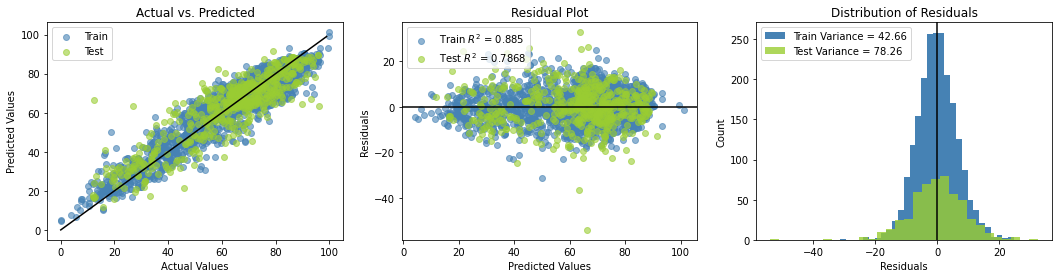

In [91]:
#Graph results
graph_residuals('ELA', 
                'High corr features removed',
                'XGBoost', 
                ELA_train, 
                ELA2_train_pred_xg, 
                ELA_test, 
                ELA2_test_pred_xg)

In [92]:
metrics.iloc[7]

Subject                                                              ELA
Features                                      High corr features removed
Algorithm                                                        XGBoost
Train r2                                                        0.885043
Train MAE                                                        5.09146
Train 95% Worst Case Error LB                                   -12.3623
Train 95% Worst Case Error UB                                    13.4954
Test r2                                                         0.786773
Test MAE                                                          6.6843
Test 95% Worst Case Error LB                                    -17.1133
Test 95% Worst Case Error UB                                     16.2636
Model                            XGBoost with High corr features removed
Name: 7, dtype: object

<a id='section5.2'></a>
### 5.1 Math Model Selection

We'll create new tables for each of our three metrics so that we can easily graph them.

In [93]:
#melt metrics2 dataframe to create r2 table
metrics_math_r2 = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                           value_vars=['Train r2', 'Test r2'],
                                                           var_name = 'Type',
                                                           value_name = 'r2')

#replace values in 'Type' column
metrics_math_r2["Type"].replace({"Train r2": "Train", 
                                 "Test r2": "Test"
                                }, 
                                inplace=True)

In [94]:
#melt metrics2 dataframe to create MAE table
metrics_math_MAE = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                            value_vars=['Train MAE', 'Test MAE'],
                                                            var_name = 'Type',
                                                            value_name = 'MAE'
                                                           )
#replace values in 'Type' column
metrics_math_MAE["Type"].replace({"Train MAE": "Train", 
                                 "Test MAE": "Test"
                                }, 
                                inplace=True)

In [95]:
#melt metrics2 dataframe to create table for worst case residuals
metrics_math_res = metrics2[metrics2['Subject']=='Math'].melt(id_vars=['Model'], 
                                                            value_vars=['Train 95% Worst Case Error LB',
                                                                        'Train 95% Worst Case Error UB',
                                                                        'Test 95% Worst Case Error LB',
                                                                        'Test 95% Worst Case Error UB'],
                                                            var_name = 'Type',
                                                            value_name = 'Worst Case'
                                                           )
#replace values in 'Type' column
metrics_math_res["Type"].replace({"Train 95% Worst Case Error LB": "Train", 
                                 "Train 95% Worst Case Error UB": "Train",
                                 'Test 95% Worst Case Error LB':'Test',
                                 'Test 95% Worst Case Error UB':'Test'
                                }, 
                                inplace=True)

We'll start by comparing the $r^2$ score of all the models.  

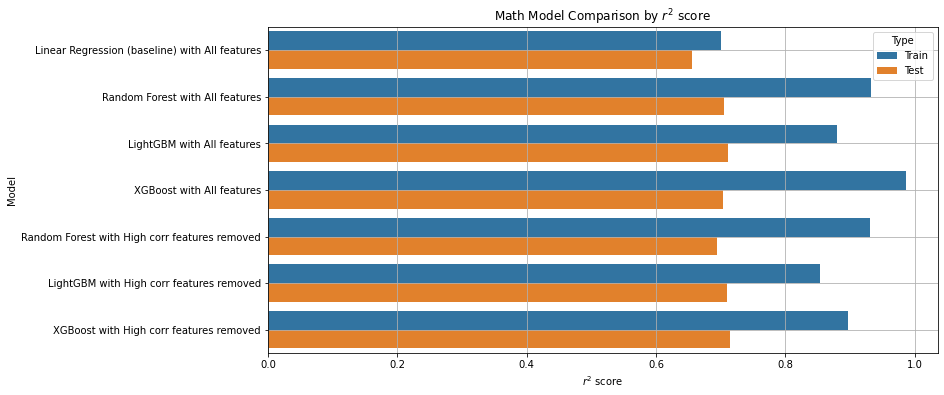

In [96]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'r2', y = 'Model', hue = 'Type', data = metrics_math_r2)
ax.set_xlabel('$r^2$ score')
ax.set_title('Math Model Comparison by $r^2$ score')
plt.grid()
plt.show()

Next we'll compare the Mean Absolute Error of our models.

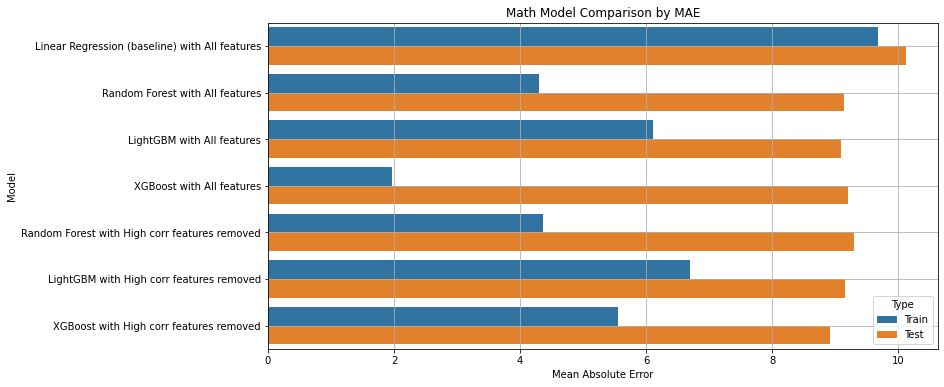

In [97]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x = 'MAE', y = 'Model', hue = 'Type', data = metrics_math_MAE)
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Math Model Comparison by MAE')
plt.grid()
plt.show()

And finally we'll compare the worst case upper and lower bounds of our residuals.

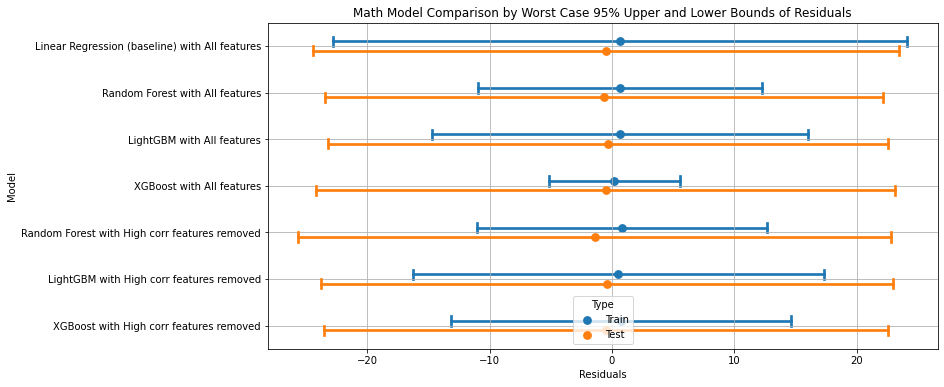

In [98]:
plt.figure(figsize=(12,6))

ax = sns.pointplot(x = 'Worst Case', 
                   y='Model', 
                   hue = 'Type', 
                   data = metrics_math_res, 
                   dodge=0.2, 
                   join=False,
                   capsize=0.2
                  )

ax.set_xlabel('Residuals')
ax.set_title('Math Model Comparison by Worst Case 95% Upper and Lower Bounds of Residuals')
plt.grid()
plt.show()

As was the case for our ELA models, there is no clear winner among our models for predicting school performance in math.  

With that said, for the purpose of moving forward with interpretability analysis for this project, we will select the <b>XGBoost</b> algorithm with the <b>high correlation features removed</b>.  Again, the models with high correlation features removed definitely generalize better with less overfitting than the models with all features included.  

Furthermore, among those three models, the XGBoost model produced the highest test $r^2$ score, the lowest test MAE, and the smallest test interval for worst case upper and lower bounds of residuals.

For reference, here are the graphs of the results and metrics from this model.

Graphs for
Target: Math Performance
Features: High corr features removed
Algorithm: XGBoost


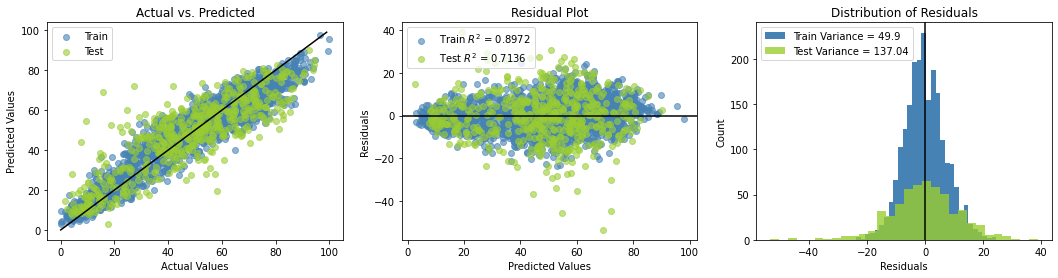

In [99]:
#Graph results
graph_residuals('Math', 
                'High corr features removed',
                'XGBoost', 
                math_train, 
                math2_train_pred_xg, 
                math_test, 
                math2_test_pred_xg)

In [100]:
metrics.iloc[13]

Subject                                                             Math
Features                                      High corr features removed
Algorithm                                                        XGBoost
Train r2                                                        0.897182
Train MAE                                                        5.55387
Train 95% Worst Case Error LB                                    -13.198
Train 95% Worst Case Error UB                                    14.6645
Test r2                                                         0.713645
Test MAE                                                         8.91724
Test 95% Worst Case Error LB                                    -23.5276
Test 95% Worst Case Error UB                                     22.5233
Model                            XGBoost with High corr features removed
Name: 13, dtype: object

<a id='section6'></a>
## 6. Feature Impact

In [101]:
import shap

<a id='section6.1'></a>
### 6.1 ELA School Performance Model

In [102]:
explainer_ELA = shap.TreeExplainer(best_xg_ELA2)
shap_values_ELA = explainer_ELA.shap_values(X=X_train2, tree_limit=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


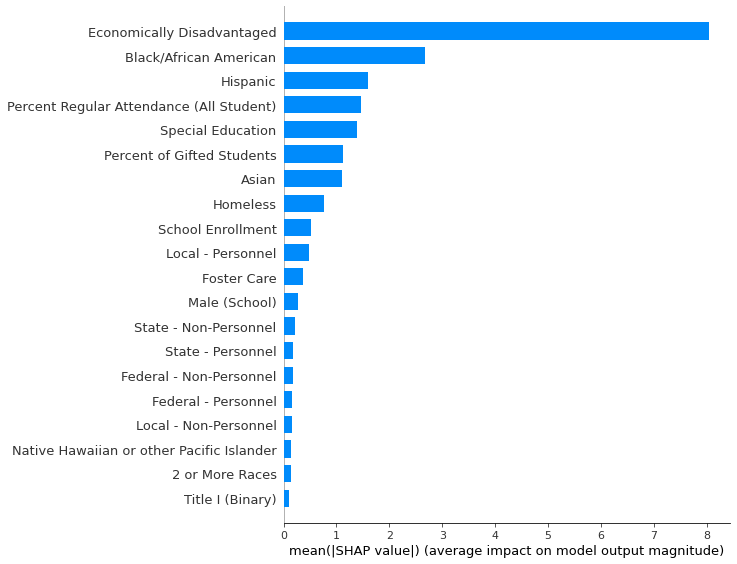

In [103]:
shap.summary_plot(shap_values_ELA, X_test2, plot_type="bar", feature_names = cols2.tolist())

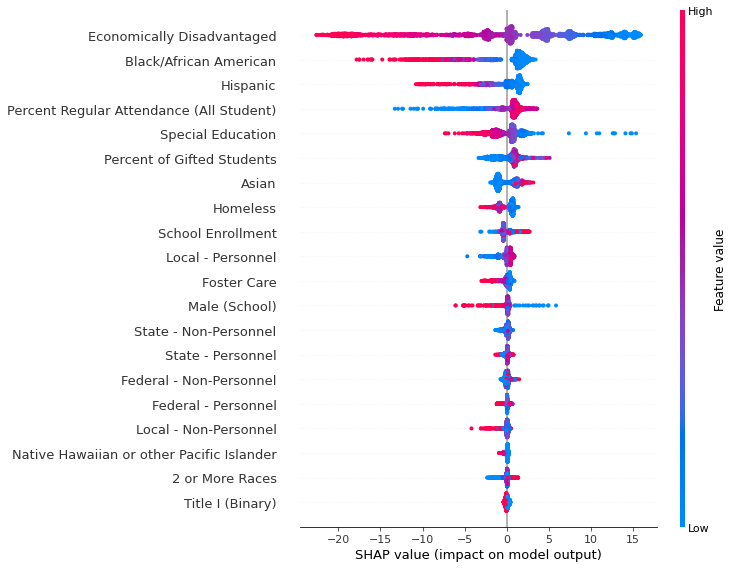

In [104]:
shap.summary_plot(shap_values_ELA, X_train2, feature_names = cols2.tolist(), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

<a id='section6.2'></a>
### 6.2 Math School Performance Model

In [105]:
explainer_math = shap.TreeExplainer(best_xg_math2)
shap_values_math = explainer_ELA.shap_values(X=X_train2, tree_limit=None)

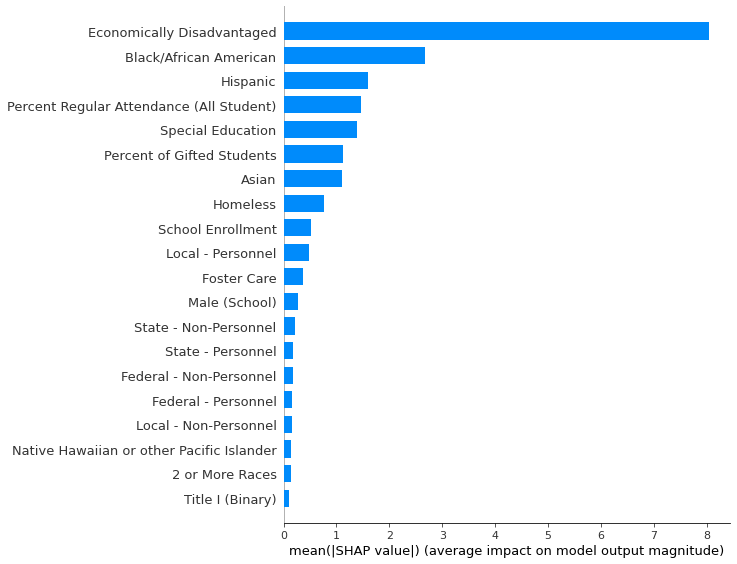

In [106]:
shap.summary_plot(shap_values_math, X_test2, plot_type="bar", feature_names = cols2.tolist())

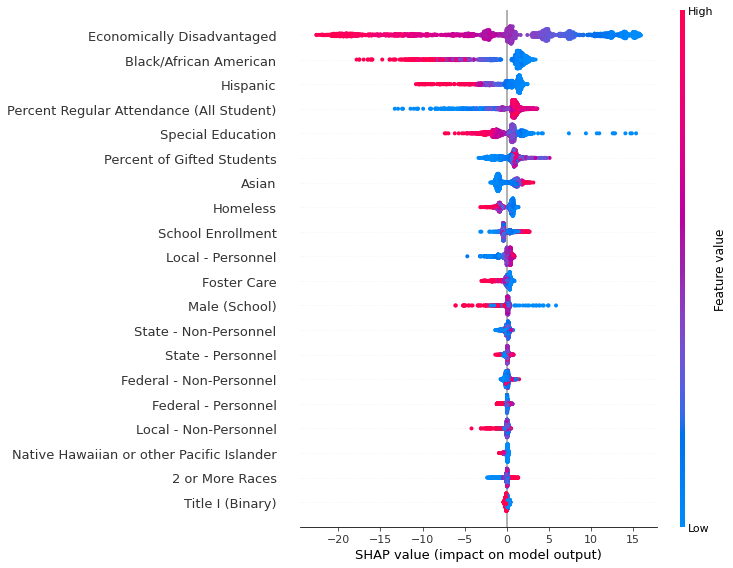

In [107]:
shap.summary_plot(shap_values_math, X_train2, feature_names = cols2.tolist(), show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

<a id='section6.3'></a>
### 6.3 Feature Impact Explanations

Our SHAP summary plots show similar trends for our models predicting school performance in ELA and Math.  For both models, the top 7 most important features based on the averages of the magnitude of the impact are as follows.  The definitions from the data dictionary are also included.

1. <b>Economically Disadvantaged</b> - The percent of students who are considered economically disadvantaged in the school based on October Student Snapshot enrollment equals the number of students identified as economically disadvantaged in the school divided by total school enrollment. 
2. <b>Black/African American</b> - The percent of Black or African American (not Hispanic) students in the school based on October Student Snapshot enrollment equals the number of Black or African American (not Hispanic) native students in the school divided by total school enrollment.
3. <b>Hispanic</b> - The percent of Hispanic students in the school based on October Student Snapshot enrollment equals the number of Hispanic native students in the school divided by total school enrollment.
4. <b>Percent Regular Attendance (All Student)</b> - This indicator is the percentage of students enrolled in a school for 90 or more school days and present 90 percent or more of these school days.
5. <b>Special Education</b> - The percent of school-age students receiving special education services in the school based on the Special Education December collection and the October Student Snapshot enrollment equals the number of students receiving special education services divided by the total school enrollment.
6. <b>Percent Gifted Students</b> - The percent of students in the school with a Gifted Individualized Education Plan (GIEP) based on October Student Snapshot enrollment equals the number of students in the school with a Gifted Individualized Education Program (GIEP) divided by the total number of students in the school.
7. <b>Asian</b> - The percent of Asian native students (not Hispanic) in the school based on October Student Snapshot enrollment equals the number of Asian native students in the school divided by total school enrollment.


We can also translate the SHAP summary plots to explain how the features impact the models in a more intuitive way.

<u>Features that <i>positively</i> impact school performance:</u>
- Lower 'Economically Disadvantaged'
- Lower 'Black/African American'
- Lower 'Hispanic'
- Higher 'Percent Regular Attendance (All Student)'
- Lower 'Special Education'

<u>Features that <i>negatively</i> impact school performance:</u>
- Higher 'Economically Disadvantaged'
- Higher 'Black/African American'
- Higher 'Hispanic'
- Lower 'Percent Regular Attendance (All Student)'
- Higher 'Special Education'
- Lower 'Percent of Gifted Students'
- Lower 'Asian'


In preparation for counterfactual explanations, we need to assess which of these features have practical potential to be altered.  It does not make sense to adjust the racial demographic percentages of a school, nor is it ethical to increase or reduce the number of students from one demographic purely to improve school performance. 

Assuming our clients for this project are state education law makers and school officials, it may be worth emphasizing the impact of the features 'Economically Disadvantaged' and 'Percent Regular Attendance (All Student)'.  Certainly, it is not feasible nor ethical to simply reduce the number of students that come from economically disadvantaged families (or increase the number of students that come from wealthier families).  However, an argument can be made for investing in the <i>local communities</i> of underperforming schools, providing support services to families whose income fall below the poverty threshold and perhaps even offering microloans to families with small businesses to expand. As for 'Percent Regular Attendance (All Student)', we can make a recommendation to our clients that increase efforts to encourage regular attendance, particularly in underperforming schools.  School officials can do this by reaching out to families and understanding the barriers of regular attendance.

What is also interesting and perhaps unexpected from our SHAP analysis is that most of our expenditure features do <i>not</i> have significant impact on school performance.  This indicates that the most effective solutions for improving school performance do not lie in simply increasing funding, but rather in connecting with the local communities of schools and improving the quality of life for struggling families. 

<a id='section7'></a>
## 7. Next steps

In our next notebook, we will analyze a school whose actual target values were 0 for both ELA and Math.  In other words, this school had 0% of students scoring proficient or above in both ELA and Math. We will provide counterfactual explanations to try to increase school performance to a predefined threshold.

Additionally, we will also discuss future work that can be done in this project.

In [108]:
#save ELA model
with open('../Models/ELA_model.pkl', 'wb') as f:
    pickle.dump(best_xg_ELA2, f)

In [109]:
#save Math model
with open('../Models/math_model.pkl', 'wb') as f:
    pickle.dump(best_xg_math2, f)

In [110]:
#save input datasets (scaled and high correlation features removed)
pd.DataFrame(X_train2, columns = cols2).to_csv('../Data/X_train_scaled2.csv')
pd.DataFrame(X_test2, columns = cols2).to_csv('../Data/X_test_scaled2.csv')